# **Initialization, Normalization, and Advanced Techniques**

# **Various Initialization Techniques**

Training with Zeros initializer...
Training with Ones initializer...
Training with Random Normal initializer...
Training with Random Uniform initializer...
Training with Glorot Normal initializer...
Training with He Normal initializer...


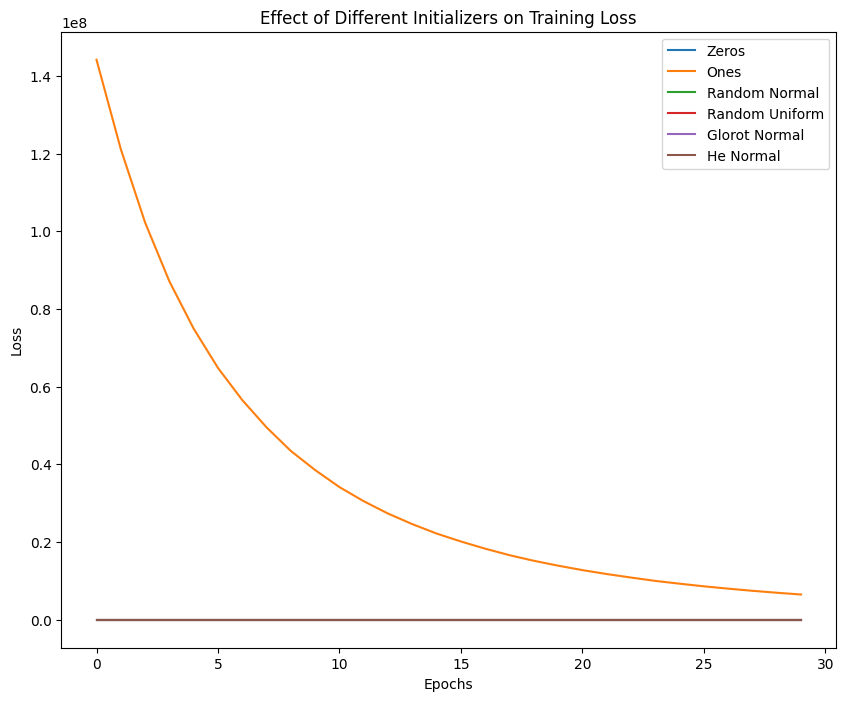

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Zeros, Ones, RandomNormal, RandomUniform, GlorotNormal, HeNormal
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_data():
    np.random.seed(0)
    X = np.random.randn(1000, 20)
    weights = np.random.randn(20, 1) * (np.arange(20) % 2)  # alternating significant weights
    y = X.dot(weights) + np.random.randn(1000, 1) * 0.1  # linear relation with noise
    return X, y

X, y = generate_data()

# Define the model with different initializers
def build_model(initializer):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],), kernel_initializer=initializer),
        Dense(64, activation='relu', kernel_initializer=initializer),
        Dense(1, kernel_initializer=initializer)
    ])
    return model

# Initializers to test with seeds
initializers = {
    'Zeros': Zeros(),
    'Ones': Ones(),
    'Random Normal': RandomNormal(mean=0.0, stddev=0.05, seed=0),
    'Random Uniform': RandomUniform(minval=-0.05, maxval=0.05, seed=0),
    'Glorot Normal': GlorotNormal(seed=0),
    'He Normal': HeNormal(seed=0)
}

# Compile, train, and plot results for each initializer
results = {}
for name, init in initializers.items():
    print(f"Training with {name} initializer...")
    model = build_model(init)
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X, y, epochs=30, verbose=0)
    results[name] = history.history['loss']

# Plotting
plt.figure(figsize=(10, 8))
for name, history in results.items():
    plt.plot(history, label=name)
plt.title('Effect of Different Initializers on Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Batch Normalization**

Epoch 1/50
25/25 [==============================] - 1s 12ms/step - loss: 6.0004 - val_loss: 4.9128
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 4.3574 - val_loss: 4.1327
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 4.1381 - val_loss: 3.9348
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 4.0654 - val_loss: 3.7968
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 3.9602 - val_loss: 3.6746
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 3.9138 - val_loss: 3.5756
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 3.9755 - val_loss: 3.5227
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 3.9568 - val_loss: 3.4850
Epoch 9/50
25/25 [==============================] - 0s 3ms/step - loss: 3.9550 - val_loss: 3.4443
Epoch 10/50
25/25 [==============================] - 0s 5ms/step - loss: 3.8670 - val_loss: 3.4179
Epoch 11/50
25/25 

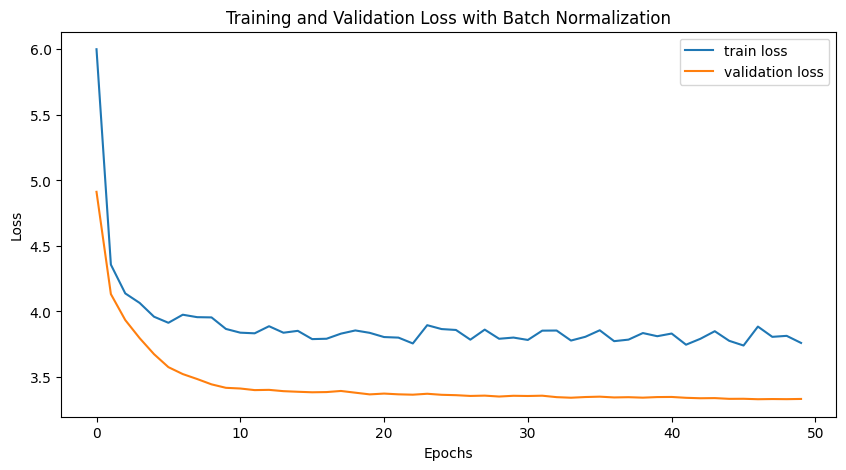

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Activation


# Reuse the generate_data function from the previous section
X, y = generate_data()

# Define the model with Batch Normalization
def build_model_with_batch_norm():
    model = Sequential([
        Dense(64, input_shape=(X.shape[1],)),
        BatchNormalization(),  # Batch Normalization layer after the dense layer
        Activation('relu'),    # Activation layer after Batch Normalization
        Dense(64),
        BatchNormalization(),
        Activation('relu'),
        Dense(1)
    ])
    return model

# Build and compile the model
model = build_model_with_batch_norm()
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=50, validation_split=0.2)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss with Batch Normalization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Custom Dropout**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

# Define a custom dropout layer
class CustomDropout(Layer):
    def __init__(self, initial_rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.initial_rate = initial_rate
        self.rate = initial_rate

    def call(self, inputs, training=None):
        if training:
            return K.dropout(inputs, self.rate)
        return inputs

    def get_config(self):
        config = super(CustomDropout, self).get_config()
        config.update({
            'initial_rate': self.initial_rate,
            'rate': self.rate
        })
        return config

# Implementing a callback to adjust the dropout rate
class DropoutScheduler(tf.keras.callbacks.Callback):
    def __init__(self, rate_scheduler, **kwargs):
        super(DropoutScheduler, self).__init__(**kwargs)
        self.rate_scheduler = rate_scheduler

    def on_epoch_end(self, epoch, logs=None):
        if not hasattr(self.model.layers[1], 'rate'):
            return
        # Schedule a new dropout rate
        new_rate = self.rate_scheduler(epoch)
        self.model.layers[1].rate = new_rate
        self.model.layers[3].rate = new_rate
        print(f"\nEpoch {epoch+1}: Dropout rate is now {new_rate:.2f}")

# Schedule function to decrease the dropout rate over time
def schedule(epoch):
    if epoch < 10:
        return 0.5
    elif epoch < 20:
        return 0.3
    else:
        return 0.1

# Building a model with custom dropout
def build_model_with_custom_dropout():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        CustomDropout(0.5),
        Dense(64, activation='relu'),
        CustomDropout(0.5),
        Dense(1)
    ])
    return model

# Generate synthetic data (reuse the generate_data function)
X, y = generate_data()

# Build and compile the model
model = build_model_with_custom_dropout()
model.compile(optimizer='adam', loss='mse')

# Train the model with Dropout Scheduler callback
model.fit(X, y, epochs=30, callbacks=[DropoutScheduler(schedule)])


Epoch 1/30
25/32 [======================>.......] - ETA: 0s - loss: 7.4307 
Epoch 1: Dropout rate is now 0.50
32/32 [==============================] - 1s 2ms/step - loss: 7.2897
Epoch 2/30
30/32 [===========================>..] - ETA: 0s - loss: 6.3632
Epoch 2: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 6.3577
Epoch 3/30
31/32 [============================>.] - ETA: 0s - loss: 5.7608
Epoch 3: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 5.7663
Epoch 4/30
32/32 [==============================] - ETA: 0s - loss: 5.4484
Epoch 4: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 5.4484
Epoch 5/30
30/32 [===========================>..] - ETA: 0s - loss: 4.9363
Epoch 5: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 4.9481
Epoch 6/30
29/32 [==========================>...] - ETA: 0s - loss: 4.7736
Epoch 6: Dropout rate is now 0.50
32/32

# **Using Callbacks**

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Learning Rate Scheduler callback
def lr_time_based_decay(epoch, lr):
    decay = epoch / 100
    new_lr = lr * 1 / (1 + decay)
    return new_lr

lr_scheduler = LearningRateScheduler(lr_time_based_decay, verbose=1)

# Model Checkpoint callback to save the best model
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)

# Train the model with both custom dropout and new callbacks
model = build_model_with_custom_dropout()
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=30,
          callbacks=[DropoutScheduler(schedule), lr_scheduler, checkpoint_cb])



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
30/32 [===========================>..] - ETA: 0s - loss: 7.2461 


Epoch 1: Dropout rate is now 0.50
32/32 [==============================] - 1s 2ms/step - loss: 7.2716 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009900990569281696.
Epoch 2/30
28/32 [=========================>....] - ETA: 0s - loss: 6.3452


Epoch 2: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 6.2735 - lr: 9.9010e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009706853341092082.
Epoch 3/30
27/32 [========================>.....] - ETA: 0s - loss: 5.7514


Epoch 3: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 5.8074 - lr: 9.7069e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009424129424128428.
Epoch 4/30
31/32 [============================>.] - ETA: 0s - loss: 5.3612


Epoch 4: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 5.3388 - lr: 9.4241e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009061662869778676.
Epoch 5/30
30/32 [===========================>..] - ETA: 0s - loss: 5.1916


Epoch 5: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 5.1665 - lr: 9.0617e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0008630154964824517.
Epoch 6/30
27/32 [========================>.....] - ETA: 0s - loss: 5.1123


Epoch 6: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 4.9705 - lr: 8.6302e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0008141655444149982.
Epoch 7/30
28/32 [=========================>....] - ETA: 0s - loss: 4.8423


Epoch 7: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 4.8113 - lr: 8.1417e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.000760902402591761.
Epoch 8/30
27/32 [========================>.....] - ETA: 0s - loss: 4.7261


Epoch 8: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 4.6783 - lr: 7.6090e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0007045392757626595.
Epoch 9/30
27/32 [========================>.....] - ETA: 0s - loss: 4.7930


Epoch 9: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 4.7461 - lr: 7.0454e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0006463663297953135.
Epoch 10/30
28/32 [=========================>....] - ETA: 0s - loss: 4.5723


Epoch 10: Dropout rate is now 0.50
32/32 [==============================] - 0s 2ms/step - loss: 4.6172 - lr: 6.4637e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0005876057548448443.
Epoch 11/30
29/32 [==========================>...] - ETA: 0s - loss: 4.5663


Epoch 11: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.5036 - lr: 5.8761e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0005293745539142741.
Epoch 12/30
28/32 [=========================>....] - ETA: 0s - loss: 4.5029


Epoch 12: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.5380 - lr: 5.2937e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.000472655873246757.
Epoch 13/30
29/32 [==========================>...] - ETA: 0s - loss: 4.3992


Epoch 13: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.5383 - lr: 4.7266e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.00041827953016731594.
Epoch 14/30
31/32 [============================>.] - ETA: 0s - loss: 4.5389


Epoch 14: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.5398 - lr: 4.1828e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0003669118629196626.
Epoch 15/30
26/32 [=======================>......] - ETA: 0s - loss: 4.4836


Epoch 15: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.4387 - lr: 3.6691e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.00031905380361106086.
Epoch 16/30
29/32 [==========================>...] - ETA: 0s - loss: 4.3978


Epoch 16: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.4541 - lr: 3.1905e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.0002750463769690872.
Epoch 17/30
29/32 [==========================>...] - ETA: 0s - loss: 4.4110


Epoch 17: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.4203 - lr: 2.7505e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00023508238462874523.
Epoch 18/30
27/32 [========================>.....] - ETA: 0s - loss: 4.2584


Epoch 18: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.4013 - lr: 2.3508e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0001992223541631158.
Epoch 19/30
29/32 [==========================>...] - ETA: 0s - loss: 4.3767


Epoch 19: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.3816 - lr: 1.9922e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.00016741374382326583.
Epoch 20/30
29/32 [==========================>...] - ETA: 0s - loss: 4.4631


Epoch 20: Dropout rate is now 0.30
32/32 [==============================] - 0s 2ms/step - loss: 4.3587 - lr: 1.6741e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0001395114547146174.
Epoch 21/30
24/32 [=====================>........] - ETA: 0s - loss: 4.5385


Epoch 21: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.3534 - lr: 1.3951e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00011529872090024643.
Epoch 22/30
27/32 [========================>.....] - ETA: 0s - loss: 4.2502


Epoch 22: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.3287 - lr: 1.1530e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.450715103904243e-05.
Epoch 23/30
27/32 [========================>.....] - ETA: 0s - loss: 4.3563


Epoch 23: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.3969 - lr: 9.4507e-05

Epoch 24: LearningRateScheduler setting learning rate to 7.683508253345887e-05.
Epoch 24/30
24/32 [=====================>........] - ETA: 0s - loss: 4.1409


Epoch 24: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.3016 - lr: 7.6835e-05

Epoch 25: LearningRateScheduler setting learning rate to 6.19637742807578e-05.
Epoch 25/30
24/32 [=====================>........] - ETA: 0s - loss: 4.2714


Epoch 25: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.3176 - lr: 6.1964e-05

Epoch 26: LearningRateScheduler setting learning rate to 4.95710177347064e-05.
Epoch 26/30
30/32 [===========================>..] - ETA: 0s - loss: 4.3166


Epoch 26: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.2981 - lr: 4.9571e-05

Epoch 27: LearningRateScheduler setting learning rate to 3.934207872214121e-05.
Epoch 27/30
28/32 [=========================>....] - ETA: 0s - loss: 4.4001


Epoch 27: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.3521 - lr: 3.9342e-05

Epoch 28: LearningRateScheduler setting learning rate to 3.097801401433865e-05.
Epoch 28/30
28/32 [=========================>....] - ETA: 0s - loss: 4.3694


Epoch 28: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.3062 - lr: 3.0978e-05

Epoch 29: LearningRateScheduler setting learning rate to 2.4201574433391215e-05.
Epoch 29/30
31/32 [============================>.] - ETA: 0s - loss: 4.3807


Epoch 29: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.3994 - lr: 2.4202e-05

Epoch 30: LearningRateScheduler setting learning rate to 1.8760910060964237e-05.
Epoch 30/30
29/32 [==========================>...] - ETA: 0s - loss: 4.3699


Epoch 30: Dropout rate is now 0.10
32/32 [==============================] - 0s 2ms/step - loss: 4.3675 - lr: 1.8761e-05


# **Keras Tuner for Hyperparameter Tuning**

In [ ]:
!pip install keras-tuner

from kerastuner import RandomSearch
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential([
        Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
              activation='relu', input_shape=(X.shape[1],)),
        CustomDropout(hp.Float('dropout', min_value=0.1, max_value=0.5, default=0.3, step=0.1)),
        Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        CustomDropout(hp.Float('dropout', min_value=0.1, max_value=0.5, default=0.3, step=0.1)),
        Dense(1)
    ])
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mse')
    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='hparam_tuning'
)

# Perform the hyperparameter tuning
print("Start hyperparameter tuning...")
tuner.search(X, y, epochs=30, validation_split=0.2, callbacks=[DropoutScheduler(schedule)])
print("Hyperparameter tuning complete.")

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters found: {best_hps.values}")


Trial 5 Complete [00h 00m 21s]
val_loss: 3.296350876490275

Best val_loss So Far: 3.2795716921488443
Total elapsed time: 00h 01m 57s
Hyperparameter tuning complete.
Best hyperparameters found: {'units': 384, 'dropout': 0.1, 'learning_rate': 0.001413751920126406}


# **Custom Callbacks**

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Do something at the start of training
        pass

    def on_epoch_end(self, epoch, logs=None):
        # Do something at the end of every epoch
        pass

    def on_train_end(self, logs=None):
        # Do something at the end of training
        pass

# Now, instantiate and use custom callback
my_callback = MyCustomCallback()

model.fit(X, y, epochs=30, validation_split=0.2, callbacks=[my_callback])


Epoch 1/30
25/25 [==============================] - 0s 8ms/step - loss: 4.3662 - val_loss: 3.5068
Epoch 2/30
25/25 [==============================] - 0s 3ms/step - loss: 4.3666 - val_loss: 3.5063
Epoch 3/30
25/25 [==============================] - 0s 3ms/step - loss: 4.4283 - val_loss: 3.5047
Epoch 4/30
25/25 [==============================] - 0s 4ms/step - loss: 4.4184 - val_loss: 3.5046
Epoch 5/30
25/25 [==============================] - 0s 4ms/step - loss: 4.3641 - val_loss: 3.5055
Epoch 6/30
25/25 [==============================] - 0s 3ms/step - loss: 4.4237 - val_loss: 3.5059
Epoch 7/30
25/25 [==============================] - 0s 3ms/step - loss: 4.3936 - val_loss: 3.5071
Epoch 8/30
25/25 [==============================] - 0s 4ms/step - loss: 4.3397 - val_loss: 3.5073
Epoch 9/30
25/25 [==============================] - 0s 3ms/step - loss: 4.4628 - val_loss: 3.5067
Epoch 10/30
25/25 [==============================] - 0s 3ms/step - loss: 4.3784 - val_loss: 3.5048
Epoch 11/30
25/25 [

# **Advanced Keras Tuner Usage**

In [ ]:
from kerastuner.tuners import BayesianOptimization

# Instantiate the Bayesian tuner
bayesian_tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hparam_bayesian'
)

# Start the search for the best hyperparameters
bayesian_tuner.search(X, y, epochs=30, validation_split=0.2, callbacks=[DropoutScheduler(schedule)])


Trial 20 Complete [00h 00m 15s]
val_loss: 3.2810946702957153

Best val_loss So Far: 3.2779747247695923
Total elapsed time: 00h 04m 28s


Hyperband Optimization:

In [ ]:
from kerastuner.tuners import Hyperband

# Instantiate the Hyperband tuner
hyperband_tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=40,
    factor=3,
    directory='my_dir',
    project_name='hparam_hyperband'
)

# Execute the hyperparameter search
hyperband_tuner.search(X, y, epochs=30, validation_split=0.2, callbacks=[DropoutScheduler(schedule)])


Trial 90 Complete [00h 00m 07s]
val_loss: 3.285996913909912

Best val_loss So Far: 3.276176691055298
Total elapsed time: 00h 04m 40s
